# Assignment 9

## Generate The Geometery and mesh using Gmsh

### Write the Geo file including the geometry specification and mesh it uisng Gmsh


In [59]:
# Generate .geo, Mesh, and Recombine
import subprocess

d_value = 1.0    # Domain size (side length)
lc_value = 0.05  # Characteristic mesh size

geo_content ="""
// Define parameters
d = 1.0;
lc =0.05;

Point(1) = {0, 0, 0, lc};
Point(2) = {0, d, 0, lc};
Point(3) = {d, d, 0, lc};
Point(4) = {d, 0, 0, lc};

Line(1) = {1, 2};
Line(2) = {2, 3};
Line(3) = {3, 4};
Line(4) = {4, 1};

Line Loop(5) = {1, 2, 3, 4};
Plane Surface(6) = {5};

// Transfinite lines for structured mesh
Transfinite Line {1, 3} = d/lc+1; // vertical divisions
Transfinite Line {2, 4} = d/lc+1; // horizontal divisions

// Transfinite surface to structure the mesh inside
Transfinite Surface {6};
Recombine Surface{6};

// Physical groups
Physical Line("Boundaries") = {1, 2, 3, 4};  // All lines
Physical Surface("Domain") = {6};
"""

geo_filename = r"C:\Users\Ahmed\Desktop\assignment\9\LidDrivenCavity.geo"
output_filename = r"C:\Users\Ahmed\Desktop\assignment\9\LidDrivenCavity.msh"
gmsh_path = r"C:\Users\Ahmed\Desktop\assignment\gmsh-4.13.1-Windows64\gmsh.exe"

with open(geo_filename, "w") as f:
    f.write(geo_content)

print(f"Wrote Gmsh script to {geo_filename}")

gmsh_command = [gmsh_path, geo_filename, "-2", "-format", "msh2", "-o", output_filename]

try:
    subprocess.run(gmsh_command, check=True)
    print(f"Mesh successfully generated and saved to {output_filename}")
except subprocess.CalledProcessError as e:
    print("Error running Gmsh:", e)


Wrote Gmsh script to C:\Users\Ahmed\Desktop\assignment\9\LidDrivenCavity.geo
Mesh successfully generated and saved to C:\Users\Ahmed\Desktop\assignment\9\LidDrivenCavity.msh


### Reading the mesh file after meshing it

In [60]:
"""import sys
print("Jupyter is using this Python executable:")
print(sys.executable)
import sys
!"{sys.executable}" -m pip install meshio
"""

import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Read the mesh file
mesh = meshio.read(output_filename)
nodes = mesh.points[:, :2]  # Only x and y if 3D
elements = mesh.cells_dict["quad"]  
# print(nodes[0:10])

### Checking if all elements are quad elements 

In [61]:
# After reading mesh with meshio
print("Cell types in mesh:", mesh.cells_dict.keys())

# Explicitly check for quads
if "quad" in mesh.cells_dict:
    elements = mesh.cells_dict["quad"]
    print(f"Mesh contains {len(elements)} quadrilateral elements")
else:
    print("Error: No quad elements found!")

Cell types in mesh: dict_keys(['line', 'quad'])
Mesh contains 400 quadrilateral elements


### Reordering before computing Jacobians

In [62]:
from numba import jit

@jit(nopython=True)
def reorder_quad_nodes(elem, nodes):
    coords = nodes[elem]
    
    # Manually compute centroid
    cx = 0.0
    cy = 0.0
    for i in range(coords.shape[0]):
        cx += coords[i, 0]
        cy += coords[i, 1]
    cx /= coords.shape[0]
    cy /= coords.shape[0]

    # Compute angles
    angles = np.empty(coords.shape[0])
    for i in range(coords.shape[0]):
        dx = coords[i, 0] - cx
        dy = coords[i, 1] - cy
        angles[i] = np.arctan2(dy, dx)

    # Sort angles
    order = np.argsort(angles)

    return elem[order]
"""
def reorder_quad_nodes(elements, nodes):
    coords = nodes[elements]
    cx, cy = coords.mean(axis=0)
    angles = np.arctan2(coords[:,1] - cy, coords[:,0] - cx)
    order = np.argsort(angles)
    return elements[order]
"""

'\ndef reorder_quad_nodes(elements, nodes):\n    coords = nodes[elements]\n    cx, cy = coords.mean(axis=0)\n    angles = np.arctan2(coords[:,1] - cy, coords[:,0] - cx)\n    order = np.argsort(angles)\n    return elements[order]\n'

### Checking the Jacobian

In [63]:
# Shape function derivatives in reference coordinates at (ξ, η) = (0, 0)
dN_dxi = np.array([
    [-0.25, -0.25],
    [ 0.25, -0.25],
    [ 0.25,  0.25],
    [-0.25,  0.25]
])

for i, elem in enumerate(elements):
    elem = reorder_quad_nodes(elem, nodes)  # Get the current element
    coords = nodes[elem]  # 4x2 matrix of node coords
    J = np.zeros((2, 2))
# i can change the order of the elements to be in a counter clockwise order by changing the raws of the elements matrix
    for a in range(4):
        J[0, 0] += dN_dxi[a, 0] * coords[a, 0]  # dx/dxi
        J[0, 1] += dN_dxi[a, 1] * coords[a, 0]  # dx/deta
        J[1, 0] += dN_dxi[a, 0] * coords[a, 1]  # dy/dxi
        J[1, 1] += dN_dxi[a, 1] * coords[a, 1]  # dy/deta

    detJ = np.linalg.det(J)

    if detJ <= 0:
        print(f"Warning: Element {i} has non-positive Jacobian determinant: {detJ}")

print("All elements have positive Jacobian determinants.")

All elements have positive Jacobian determinants.


### Checking the aspect ratio of each element

In [64]:
@jit(nopython=True)
def element_aspect_ratio(nodes):
    """Calculate edge length ratios for quadrilateral"""
    coords = nodes[:, :2]
    edge_lengths = []
    for i in range(4):
        j = (i+1)%4
        dx = coords[j][0] - coords[i][0]
        dy = coords[j][1] - coords[i][1]
        edge_lengths.append(np.sqrt(dx**2 + dy**2))
    return max(edge_lengths)/min(edge_lengths)

aspect_ratios = []
for elem in elements:
    aspect_ratios.append(element_aspect_ratio(nodes[elem]))

print(f"Aspect ratio statistics:")
print(f"Min: {np.min(aspect_ratios):.2f}")
print(f"Max: {np.max(aspect_ratios):.2f}")
print(f"Mean: {np.mean(aspect_ratios):.2f}")

# Highlight poor elements
threshold = 5.0
bad_elements = [elem for elem, ar in zip(elements, aspect_ratios) if ar > threshold]
print(f"Found {len(bad_elements)} elements with AR > {threshold}")

Aspect ratio statistics:
Min: 1.00
Max: 1.00
Mean: 1.00
Found 0 elements with AR > 5.0


### Creating plotting for visulization

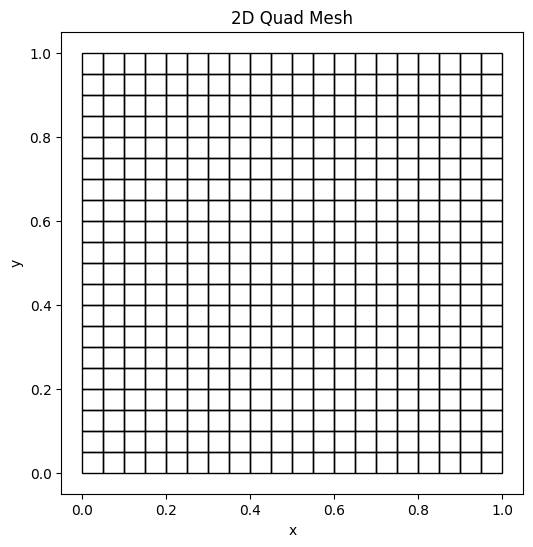

In [65]:
# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))
for element in elements:
    # Get the coordinates of the 4 nodes of the quadrilateral
    quad_coords = nodes[element]
    # Close the loop by repeating the first point
    quad_coords = quad_coords.tolist() + [quad_coords[0].tolist()]
    # Create a polygon and add it to the plot
    polygon = patches.Polygon(quad_coords, edgecolor='black', facecolor='none')
    ax.add_patch(polygon)

# Adjust plot limits
ax.set_aspect('equal')
ax.autoscale()
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Quad Mesh")
plt.show()

## 2D FEM solver using GLS for N-S Equations

In [66]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# Double precision setup
DTYPE = np.float64

# Quadrature parameters
GAUSS_POINTS = 3
GAUSS_WEIGHTS = np.array([5/9, 8/9, 5/9], dtype=DTYPE)  # For 3-point Gauss-Legendre

# Define simulation parameters 
Re = 1000    # Reynolds number
dt = 0.0005      # Time step
Nt = 81000        # Number of time steps
pressure_nodes = [0]  # Node where p=0 is enforced
nu = 1.0 / Re  # Kinematic viscosity

# --------------------------
# Shape functions and derivatives (Q1 elements)
# --------------------------
@jit(nopython=True)
def shape_functions(xi, eta):
    N = 0.25 * np.array([
        (1 - xi)*(1 - eta),
        (1 + xi)*(1 - eta),
        (1 + xi)*(1 + eta),
        (1 - xi)*(1 + eta)
    ], dtype=DTYPE)
    
    dN_dxi = 0.25 * np.array([
    [-(1 - eta), -(1 - xi)],   # dN1/dxi, dN1/deta
    [ (1 - eta), -(1 + xi)],   # dN2/dxi, dN2/deta
    [ (1 + eta),  (1 + xi)],   # dN3/dxi, dN3/deta
    [-(1 + eta),  (1 - xi)]    # dN4/dxi, dN4/deta
    ], dtype=DTYPE)
    
    return N, dN_dxi

# --------------------------
# Global matrix assembly
# --------------------------
def assemble_global(nodes, elements):
    NNodes = nodes.shape[0]
    NElem = elements.shape[0]

    # Pressure matrix (K) and mass lumped vector (MLV)
    K_p = sp.lil_matrix((NNodes, NNodes), dtype=DTYPE)  # Pressure stiffness matrix
    MLV = np.zeros(NNodes, dtype=DTYPE)                 # Mass lumped vector
    G_x = sp.lil_matrix((NNodes, NNodes), dtype=DTYPE)  # Gradient operators
    G_y = sp.lil_matrix((NNodes, NNodes), dtype=DTYPE)

    for e in range(NElem):
        elem_nodes = reorder_quad_nodes(elements[e], nodes)
        x = nodes[elem_nodes, 0]
        y = nodes[elem_nodes, 1]
        
        K_local = np.zeros((4,4), dtype=DTYPE)
        Gx_local = np.zeros((4,4), dtype=DTYPE)
        Gy_local = np.zeros((4,4), dtype=DTYPE)
        MLV_local = np.zeros(4, dtype=DTYPE)

        # Gauss quadrature integration
        for i in range(GAUSS_POINTS):
            xi = np.sqrt(3/5)*np.array([-1, 0, 1])[i]
            w_i = GAUSS_WEIGHTS[i]
            
            for j in range(GAUSS_POINTS):
                eta = np.sqrt(3/5)*np.array([-1, 0, 1])[j]
                w_j = GAUSS_WEIGHTS[j]
                
                N, dN_dxi = shape_functions(xi, eta)
                
                # Jacobian matrix
                dx_dxi = np.dot(dN_dxi[:, 0], x)
                dy_dxi = np.dot(dN_dxi[:, 0], y)
                dx_deta = np.dot(dN_dxi[:, 1], x)
                dy_deta = np.dot(dN_dxi[:, 1], y)

                J = np.array([[dx_dxi, dx_deta],
                            [dy_dxi, dy_deta]], dtype=DTYPE)
                
                detJ = np.linalg.det(J)
                invJ = np.linalg.inv(J)
                """
                if detJ < 0:
                    print(f"Warning: Negative determinant in element , detJ = {detJ}")
                elif np.isnan(detJ):
                    print(f"Warning: NaN determinant in element ")
                """
                # Shape function derivatives in physical coordinates
                dN_dx = invJ[0,0]*dN_dxi[:,0] + invJ[0,1]*dN_dxi[:,1]
                dN_dy = invJ[1,0]*dN_dxi[:,0] + invJ[1,1]*dN_dxi[:,1]
                
                # Pressure matrix terms (∇N_i·∇N_j)
                K_local += np.outer(dN_dx, dN_dx) * w_i * w_j * detJ
                K_local += np.outer(dN_dy, dN_dy) * w_i * w_j * detJ
                
                # Gradient operators
                Gx_local += np.outer(N, dN_dx) * w_i * w_j * detJ
                Gy_local += np.outer(N, dN_dy) * w_i * w_j * detJ
                
                # Mass lumped vector
                MLV_local += N * w_i * w_j * detJ

        # Assemble global matrices
        for r in range(4):
            MLV[elem_nodes[r]] += MLV_local[r]
            for s in range(4):
                K_p[elem_nodes[r], elem_nodes[s]] += K_local[r,s]
                G_x[elem_nodes[r], elem_nodes[s]] += Gx_local[r,s]
                G_y[elem_nodes[r], elem_nodes[s]] += Gy_local[r,s]

    return K_p.tocsr(), G_x.tocsr(), G_y.tocsr(), MLV

# --------------------------
# Pressure Solver
# --------------------------
def solve_pressure(K_p, G_x, G_y, MLV, u, v, epsilon):
    # Compute divergence source term
    div_u = G_x @ u + G_y @ v
    R_p = - (1 / epsilon) * MLV * div_u
    
    # Apply pressure BCs (p=0 at boundary nodes)
    K_p = K_p.tolil()
    for node in pressure_nodes:
        K_p[node,:] = 0
        K_p[node,node] = 1.0
        R_p[node] = 0.0
    
    # Solve pressure system
    p = sp.linalg.spsolve(K_p.tocsc(), R_p)
    return p

# --------------------------
# Momentum Solver with GLS
# --------------------------
@jit(nopython=True)
def solve_momentum(nodes, elements, MLV, u, v, p, Re, dt):
    nu = 1.0 / Re
    NNodes = nodes.shape[0]
    R_u = np.zeros(NNodes, dtype=DTYPE)
    R_v = np.zeros(NNodes, dtype=DTYPE)

    for e in range(len(elements)):
        elem_nodes = reorder_quad_nodes(elements[e], nodes)
        x = nodes[elem_nodes, 0]
        y = nodes[elem_nodes, 1]
        u_e = u[elem_nodes]
        v_e = v[elem_nodes]
        p_e = p[elem_nodes]

        for i in range(GAUSS_POINTS):
            xi = np.sqrt(3/5)*np.array([-1, 0, 1])[i]
            w_i = GAUSS_WEIGHTS[i]
            
            for j in range(GAUSS_POINTS):
                eta = np.sqrt(3/5)*np.array([-1, 0, 1])[j]
                w_j = GAUSS_WEIGHTS[j]
                
                N, dN_dxi = shape_functions(xi, eta)
                
                # Jacobian and derivatives
                dx_dxi = np.dot(dN_dxi[:, 0], x)
                dy_dxi = np.dot(dN_dxi[:, 0], y)
                dx_deta = np.dot(dN_dxi[:, 1], x)
                dy_deta = np.dot(dN_dxi[:, 1], y)

                J = np.array([[dx_dxi, dx_deta],
                            [dy_dxi, dy_deta]], dtype=DTYPE)
                detJ = np.linalg.det(J)
                invJ = np.linalg.inv(J)
                
                """
                if detJ < 0:
                    print(f"Warning: Negative determinant in element , detJ = {detJ}")
                elif np.isnan(detJ):
                    print(f"Warning: NaN determinant in element ")
                """
                
                dN_dx = invJ[0,0]*dN_dxi[:,0] + invJ[0,1]*dN_dxi[:,1]
                dN_dy = invJ[1,0]*dN_dxi[:,0] + invJ[1,1]*dN_dxi[:,1]
                
                # Interpolated values
                u_g = N @ u_e
                v_g = N @ v_e
                p_g = N @ p_e
                
                # Gradients
                u_x = dN_dx @ u_e
                u_y = dN_dy @ u_e
                v_x = dN_dx @ v_e
                v_y = dN_dy @ v_e
                p_x = dN_dx @ p_e
                p_y = dN_dy @ p_e
                
                # Stabilization parameters
                h = np.sqrt(detJ)
                vel_mag = np.sqrt(u_g**2 + v_g**2 + 1e-12)
                Pe = (vel_mag * h) / (2 * nu)
                tau = 1.0 / np.sqrt((2*Pe/h)**2 + (4*nu/h**2)**2 + (2/dt)**2)
                tau = min(tau, dt)
                # GLS weighting functions
                w_u = N + tau * (u_g * dN_dx + v_g * dN_dy)
                w_v = N + tau * (u_g * dN_dx + v_g * dN_dy)

                # X-momentum residual
                conv = u_g*u_x + v_g*u_y
                press = p_x
                diff = nu * (u_x*dN_dx + u_y*dN_dy)
                R_u[elem_nodes] -= dt * (conv*w_u + press*w_u + diff) * w_i * w_j * detJ  #we can replace w_u with N

                # Y-momentum residual
                conv = u_g*v_x + v_g*v_y
                press = p_y
                diff = nu * (v_x*dN_dx + v_y*dN_dy)
                R_v[elem_nodes] -= dt * (conv*w_v + press*w_v  + diff) * w_i * w_j * detJ  #we can replace w_u with N

    # Explicit update with lumped mass matrix
    u_new = (MLV * u + R_u) / MLV
    v_new = (MLV * v + R_v) / MLV
    
    return u_new, v_new

# --------------------------
# Time Stepping
# --------------------------
def solve_ns(nodes, elements, pressure_nodes):
    # Initialization
    K_p, G_x, G_y, MLV = assemble_global(nodes, elements)
    u = np.zeros(nodes.shape[0], dtype=DTYPE)
    v = np.zeros(nodes.shape[0], dtype=DTYPE)
    p = np.zeros(nodes.shape[0], dtype=DTYPE)
    epsilon = 0.001  # Stabilization parameter
    residuals_mass = []
    residuals_vel = []
    times = []
    start_time = time.time()
    for n in range(Nt):
        # Pressure solve
        p = solve_pressure(K_p, G_x, G_y, MLV, u, v, epsilon)
        
        # Momentum solve
        u_new, v_new = solve_momentum(nodes, elements, MLV, u, v, p, Re, dt)
        # Compute residual: norm of divergence (mass conservation)
        div_u = G_x @ u + G_y @ v
        res = np.linalg.norm(div_u)
        residuals_mass.append(res)
        times.append(n * dt)
        
        # Compute residual (L2 norm of velocity update)
        res_u = np.linalg.norm(u_new - u) / (np.linalg.norm(u) + 1e-12)
        res_v = np.linalg.norm(v_new - v) / (np.linalg.norm(v) + 1e-12)
        res_total = np.sqrt(res_u**2 + res_v**2)
        residuals_vel.append(res_total)
        
        if n % 10000 == 0:
            print(f"Completed step {n}/{Nt} (t = {(n)*dt:.4f})")
            print(f"Step {n}/{Nt}, Mass_Residual = {res:.2e}")
            print(f"Step {n}/{Nt}: Velocity_Residual = {res_total:.2e}")
            
        # Update velocities
        u = u_new.copy()
        v = v_new.copy()
        
        # Apply boundary conditions
        apply_velocity_bc(u, v, nodes)
        
    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal solve time: {total_time:.2f} seconds")
    
    # Plot residuals
    plt.figure(figsize=(8,5))
    plt.plot(times, residuals_mass, label="Mass Residual", color='blue', linestyle='--')
    plt.plot(times, residuals_vel, label="Velocity Residual", color='red', linestyle='--')
    plt.yscale('log')
    plt.xlabel("Time [s]")
    plt.ylabel("Residual")
    plt.title("Residual vs Time")
    plt.grid(True)
    plt.legend()
    plt.show()

    return u, v, p

# --------------------
# Boundary condition
# --------------------
@jit(nopython=True)
def apply_velocity_bc(u, v, nodes, tol=1e-6):
    x = nodes[:, 0]
    y = nodes[:, 1]

    lid_nodes = np.where(np.abs(y - 1.0) < tol)[0]
    wall_nodes = np.where(
        (np.abs(x) < tol) | (np.abs(x - 1.0) < tol) | (np.abs(y) < tol)
    )[0]

    u[wall_nodes] = 0.0
    v[wall_nodes] = 0.0

    u[lid_nodes] = 1.0
    v[lid_nodes] = 0.0

    return u, v

            


Starting simulation...
Completed step 0/81000 (t = 0.0000)
Step 0/81000, Mass_Residual = 0.00e+00
Step 0/81000: Velocity_Residual = 0.00e+00
Completed step 10000/81000 (t = 5.0000)
Step 10000/81000, Mass_Residual = 1.57e-02
Step 10000/81000: Velocity_Residual = 9.34e-04
Completed step 20000/81000 (t = 10.0000)
Step 20000/81000, Mass_Residual = 1.59e-02
Step 20000/81000: Velocity_Residual = 9.12e-04
Completed step 30000/81000 (t = 15.0000)
Step 30000/81000, Mass_Residual = 1.59e-02
Step 30000/81000: Velocity_Residual = 8.93e-04
Completed step 40000/81000 (t = 20.0000)
Step 40000/81000, Mass_Residual = 1.59e-02
Step 40000/81000: Velocity_Residual = 8.81e-04
Completed step 50000/81000 (t = 25.0000)
Step 50000/81000, Mass_Residual = 1.59e-02
Step 50000/81000: Velocity_Residual = 8.74e-04
Completed step 60000/81000 (t = 30.0000)
Step 60000/81000, Mass_Residual = 1.59e-02
Step 60000/81000: Velocity_Residual = 8.70e-04
Completed step 70000/81000 (t = 35.0000)
Step 70000/81000, Mass_Residual =

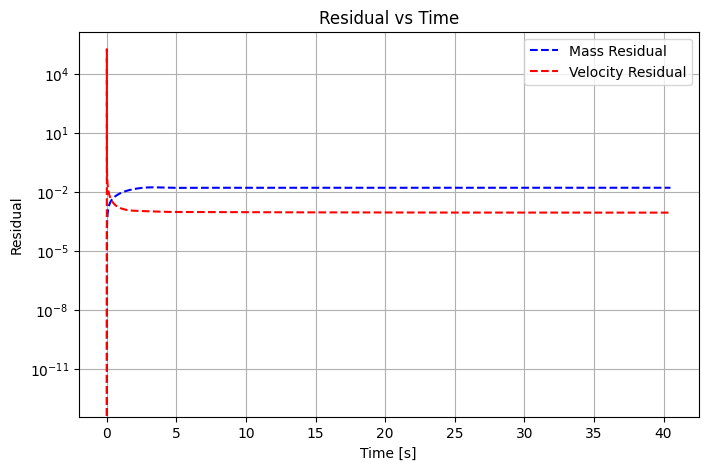

Simulation completed!


In [67]:
# --------------------------
# Main execution
# --------------------------

# Solve Navier-Stokes
print("Starting simulation...")
u, v, p = solve_ns(nodes, elements, pressure_nodes)

print("Simulation completed!")

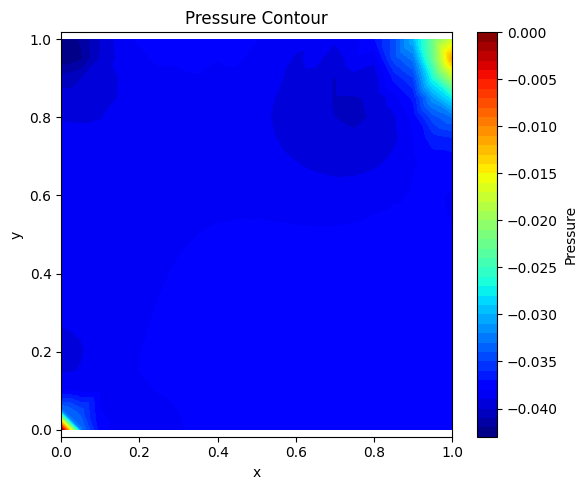

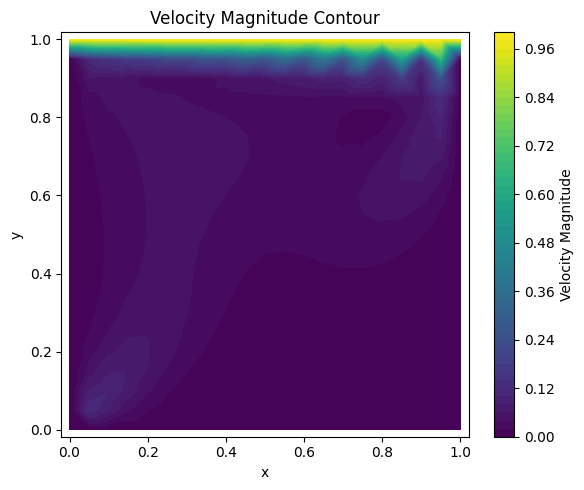

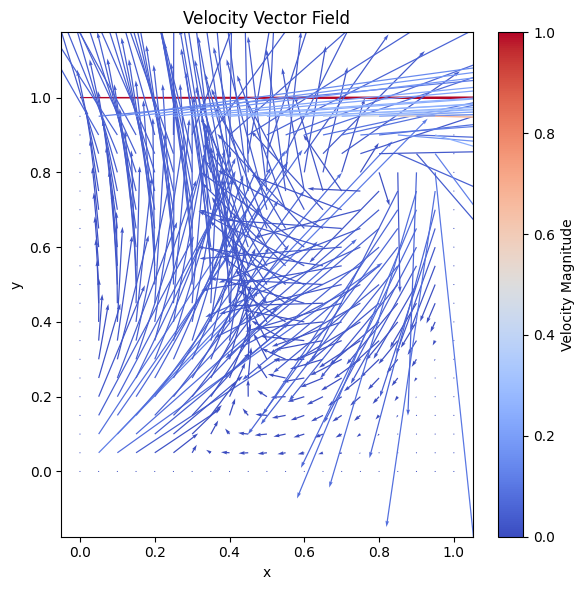

In [68]:
import matplotlib.tri as tri

# Extract node coordinates
x = nodes[:, 0]
y = nodes[:, 1]

# Velocity magnitude for contour
velocity_magnitude = np.sqrt(u**2 + v**2)

# Create unstructured triangulation for contour plotting
triang = tri.Triangulation(x, y)

# --- Pressure Contour ---
plt.figure(figsize=(6, 5))
plt.tricontourf(triang, p, levels=50, cmap='jet')
plt.colorbar(label="Pressure")
plt.title("Pressure Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

# --- Velocity Magnitude Contour ---
plt.figure(figsize=(6, 5))
plt.tricontourf(triang, velocity_magnitude, levels=50, cmap='viridis')
plt.colorbar(label="Velocity Magnitude")
plt.title("Velocity Magnitude Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

# --- Velocity Vector Field (Quiver Plot) ---
plt.figure(figsize=(6, 6))
plt.quiver(x, y, u, v, velocity_magnitude, cmap='coolwarm', scale=0.1, color='red', width=0.003, headwidth=3)
plt.title("Velocity Vector Field")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Velocity Magnitude")
plt.axis("equal")
plt.tight_layout()
plt.show()



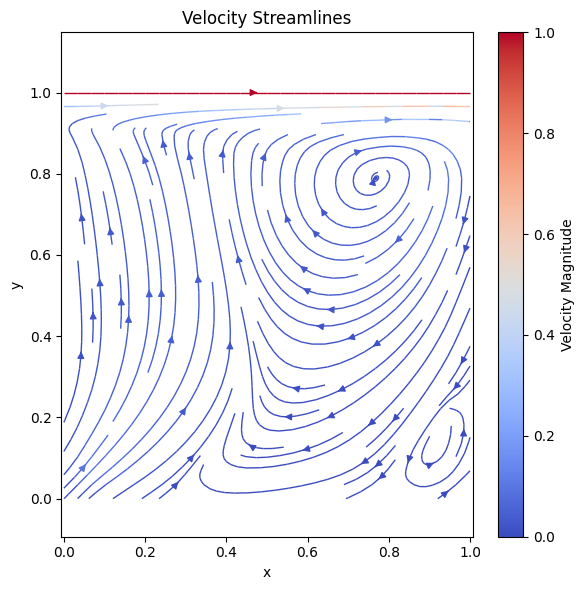

In [69]:
# Round to eliminate floating point noise (adjust decimal as needed)
x_rounded = np.round(nodes[:, 0], decimals=8)
y_rounded = np.round(nodes[:, 1], decimals=8)

x_unique = np.unique(x_rounded)
y_unique = np.unique(y_rounded)

nx = len(x_unique)
ny = len(y_unique)

# Now reshape
X, Y = np.meshgrid(x_unique, y_unique)

# Sort nodes into a grid-friendly order
# This assumes node order corresponds to a regular grid in row-major (y-fast) order

# Create a mapping from (x, y) to velocity
from scipy.spatial import cKDTree

grid_points = np.column_stack([X.ravel(), Y.ravel()])
tree = cKDTree(nodes)

# Find nearest node for each grid point
_, idx = tree.query(grid_points)

# Assign velocities to the grid
U = u[idx].reshape((ny, nx))
V = v[idx].reshape((ny, nx))

# Plot streamlines
plt.figure(figsize=(6, 6))
plt.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), cmap='coolwarm', linewidth=1)
plt.title("Velocity Streamlines")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Velocity Magnitude")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [70]:
def compute_vortex_length(u_nodal, nodes, x_range=(0.0, 1.0), y_range=(0.0, 1.0), threshold=-1e-5):
    x, y = nodes[:, 0], nodes[:, 1]
    mask = (
        (x >= x_range[0]) & (x <= x_range[1]) &
        (y >= y_range[0]) & (y <= y_range[1]) &
        (u_nodal < threshold)
    )
    
    if not np.any(mask):
        print("No reversed flow detected in the specified region.")
        return 0.0
    
    x_coords = x[mask]
    vortex_length = x_coords.max() - x_coords.min()
    print(f"Detected vortex length φ = {vortex_length:.4f} m")
    return vortex_length

vor_len = compute_vortex_length(u, nodes, x_range=(0.0, 1.0), y_range=(0.0, 1.0), threshold=-1e-5)
print(f"Vortex length: {vor_len:.4f} m")

Detected vortex length φ = 0.9000 m
Vortex length: 0.9000 m


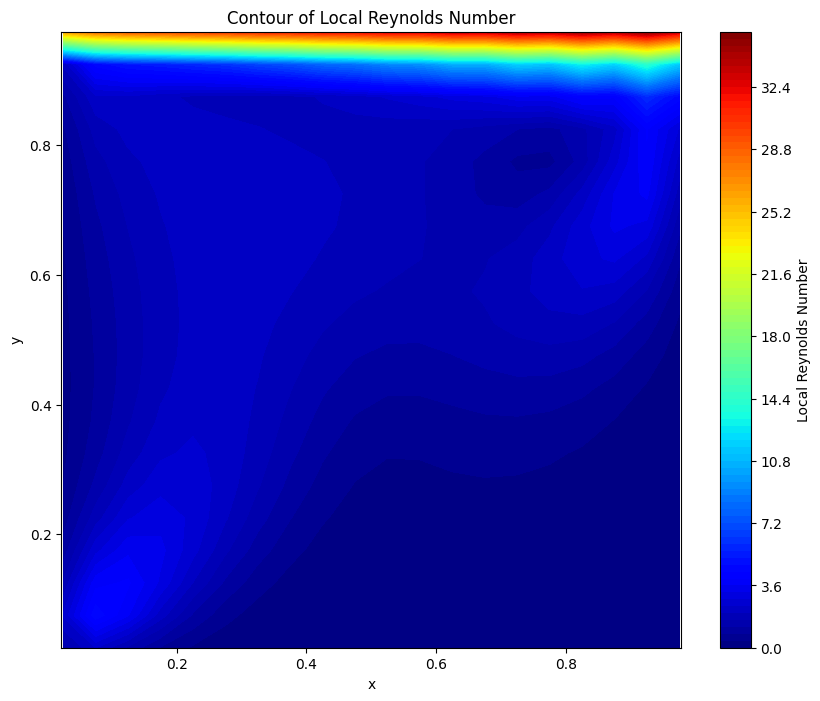

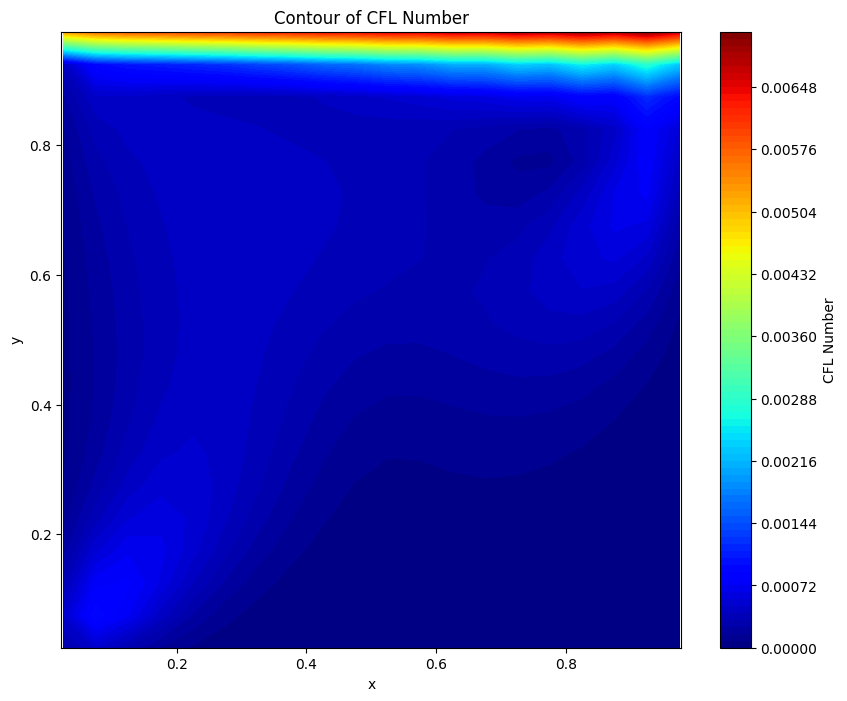

In [71]:
# Compute local Reynolds number (Re_loc) and CFL number for each element
Re_global = Re  # Global Reynolds number from problem setup

Re_loc = []
CFL = []
x_centers = []
y_centers = []

for elem in elements:
    # Reorder element nodes to ensure counter-clockwise ordering
    elem_nodes = reorder_quad_nodes(elem, nodes)
    coords = nodes[elem_nodes]
    
    # Extract velocities at element nodes
    u_e = u[elem_nodes]
    v_e = v[elem_nodes]
    
    # Calculate average velocity magnitude in the element
    U_e = np.mean(np.sqrt(u_e**2 + v_e**2))
    
    # Compute element area using shoelace formula
    x = coords[:, 0]
    y = coords[:, 1]
    area = 0.5 * abs(
        (x[0]*y[1] - x[1]*y[0]) +
        (x[1]*y[2] - x[2]*y[1]) +
        (x[2]*y[3] - x[3]*y[2]) +
        (x[3]*y[0] - x[0]*y[3])
    )
    l_e = np.sqrt(area)  # Characteristic length
    
    # Compute Re_loc and CFL
    Re_loc_val = U_e * l_e / nu
    CFL_val = (U_e * dt) / l_e
    
    Re_loc.append(Re_loc_val)
    CFL.append(CFL_val)
    
    # Element center coordinates
    x_centers.append(np.mean(x))
    y_centers.append(np.mean(y))

# Convert to numpy arrays
Re_loc = np.array(Re_loc)
CFL = np.array(CFL)
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)

# Reshape data into structured grid (20x20 elements)
nx = ny = int(d_value // lc_value + 1) # Number of nodes in x and y directions
X = x_centers.reshape(nx, ny)
Y = y_centers.reshape(nx, ny)
Re_loc_grid = Re_loc.reshape(nx, ny)
CFL_grid = CFL.reshape(nx, ny)

# Plot Re_loc contour
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Re_loc_grid, levels=100, cmap='jet')
plt.colorbar(contour, label='Local Reynolds Number')
plt.title('Contour of Local Reynolds Number')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

# Plot CFL contour
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, CFL_grid, levels=100, cmap='jet')
plt.colorbar(contour, label='CFL Number')
plt.title('Contour of CFL Number')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()